In [17]:
from scipy.ndimage import label
import numpy as np
from gp_model import GaussField, PlaceField1D, PlaceFieldModel1D, PlaceFieldComparison, PlaceField2D
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.stats import rayleigh
from scipy import ndimage,optimize, stats
from collections import deque


def simulate_data(theta=1, sigma=1, N = 1000, res = 0.05, width = 3.5, height = 2.5):
  """
  simulates the place field in 3.5m * 2.5m environment with bin size of res.
  It returns array of thresholded rate maps of size N.
  
  Input:
    theta, sigma: threshold and  correlation  length
    N: size of the output array
    res: bin size (initialized to 5cm)
  """
  width = width
  height =  height
  simulated_data = []
  for _ in range(N):
    field = gaussian_filter(np.random.normal(0, 1, [int(height / res),int(width / res)]), sigma = sigma/res, mode="wrap")
    field = field / (np.sqrt(np.mean(field**2)))
    field = field - theta
    field[field < 0] = 0
    simulated_data.append(field)
  return np.array(simulated_data)

도형별 넓이/peak: [(5, (0, 3), np.int64(10)), (3, (0, 6), np.int64(100)), (4, (3, 0), np.int64(8)), (6, (3, 4), np.int64(7))]


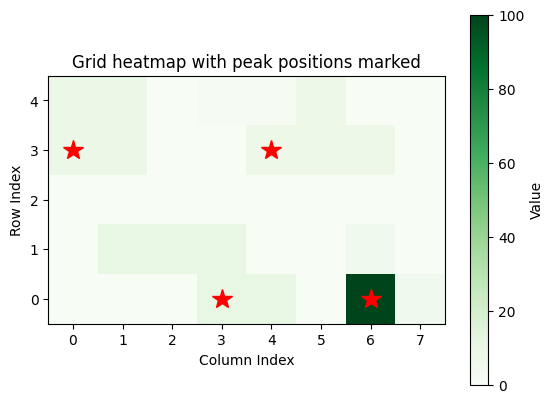

In [18]:
# Finding the peaks from the place fields
def bfs_areas_and_peaks(grid):
    rows, cols = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    components_info = []
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    for r in range(rows):
        for c in range(cols):
            if grid[r, c] != 0 and not visited[r, c]:
                queue = deque()
                queue.append((r, c))
                visited[r, c] = True
                size = 0
                peak_value = grid[r, c]
                peak_pos = (r, c)
                while queue:
                    x, y = queue.popleft()
                    size += 1
                    if grid[x, y] > peak_value:
                        peak_value = grid[x, y]
                        peak_pos = (x, y)
                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols:
                            if grid[nx, ny] != 0 and not visited[nx, ny]:
                                visited[nx, ny] = True
                                queue.append((nx, ny))
                components_info.append((size, peak_pos, peak_value))
    return components_info

# 예시 배열
example_grid = np.array([
    [0, 0, 0, 10, 10, 0, 100, 5],
    [0, 10, 10, 10, 0, 0, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 0, 7, 7, 7, 0],
    [8, 8, 0, 1, 1, 7, 0, 0]
])

comp_info = bfs_areas_and_peaks(example_grid)
print('도형별 넓이/peak:', comp_info)

# 시각화
plt.imshow(example_grid, cmap='Greens', interpolation='nearest')
plt.colorbar(label='Value')
for info in comp_info:
    _, (r, c), _ = info
    plt.plot(c, r, marker='*', color='red', markersize=15)
plt.title('Grid heatmap with peak positions marked')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.gca().invert_yaxis()
plt.show()

도형별 넓이/peak: [(1157, (23, 50), np.float64(1.4993115446981078)), (154, (24, 0), np.float64(0.6502960250998677))]


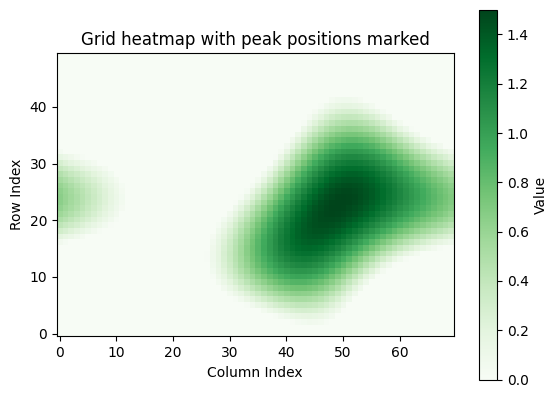

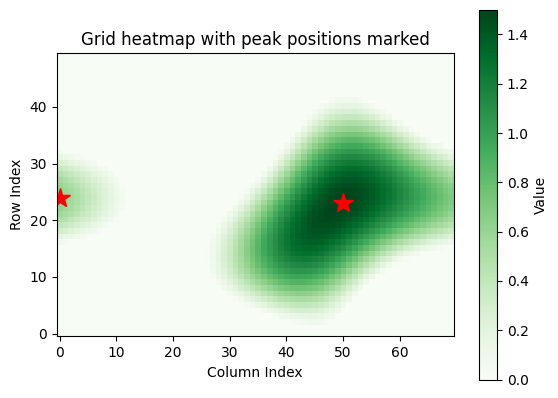

In [21]:
# parameter fitted from tanni's  data
simulated_data = simulate_data(0.8,0.5)

#Visualization example of place fields from rate map
comp_info = bfs_areas_and_peaks(simulated_data[0])
print('도형별 넓이/peak:', comp_info)
plt.imshow(simulated_data[0], cmap='Greens', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Grid heatmap with peak positions marked')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.gca().invert_yaxis()
plt.show()

plt.imshow(simulated_data[0], cmap='Greens', interpolation='nearest')
plt.colorbar(label='Value')
for info in comp_info:
    _, (r, c), _ = info
    plt.plot(c, r, marker='*', color='red', markersize=15)
plt.title('Grid heatmap with peak positions marked')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.gca().invert_yaxis()
plt.show()

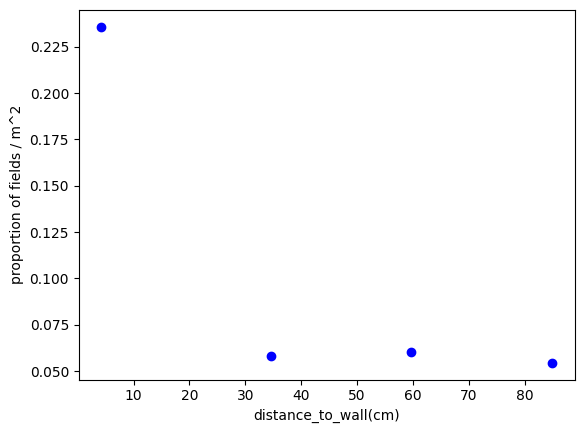

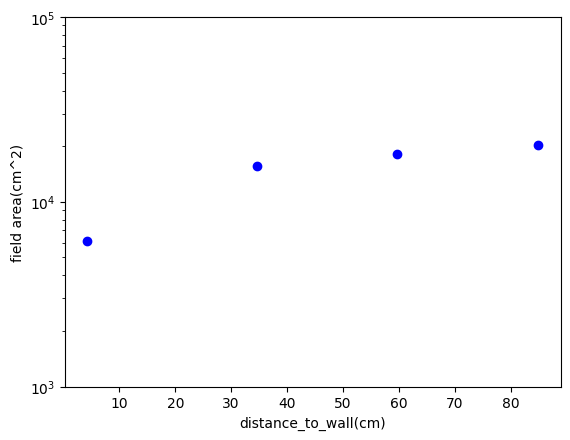

In [ ]:
simulated_data = simulate_data(0.8,0.5)

def calculate_dist_from_wall(x,y):
  dist1 = np.abs(x)
  dist2 = np.abs(x - int(2.5/0.05))
  dist3 = np.abs(y)
  dist4 = np.abs(y - int(3.5/0.05))
  return np.min([dist1,dist2,dist3,dist4])

for data in simulated_data:
  arr = bfs_areas_and_peaks(data)
  result += arr

x = [calculate_dist_from_wall(*(pair[1])) * 5 for pair in result] # list of the distances from the wall of each peak 
y = [pair[0] * 25 for pair in result]  #list of sizes of place fields

area_dict = {0:0,1:0,2:0,3:0,4:0,5:0}
dist_dict = {0:0,1:0,2:0,3:0,4:0,5:0}
cnt_dict = {0:0,1:0,2:0,3:0,4:0,5:0}

# categorizing the data with the bin size(25cm)
for i in range(len(x)):
  dist = x[i]
  area = y[i]
  area_dict[dist // 25] += area
  dist_dict[dist // 25] += dist
  cnt_dict[dist//25] += 1

propotion_of_fields_per_area = []
area_result = []
dist_from_wall = []
bin_area = [2.75,2.25,1.75,1.25,1,0.75]
for i  in  cnt_dict.keys():
  propotion_of_fields_per_area.append((cnt_dict[i] / len(result)) / bin_area[i])
  area_result.append(area_dict[i] / cnt_dict[i])
  dist_from_wall.append(dist_dict[i]/ cnt_dict[i])

plt.scatter(dist_from_wall[:-2], propotion_of_fields_per_area[:-2], color='blue', marker='o')  # 점만 찍기
plt.xlabel('distance_to_wall(cm)')
plt.ylabel('proportion of fields / m^2')
plt.show()
plt.scatter(dist_from_wall[:-2], area_result[:-2], color='blue', marker='o')  # 점만 찍기
plt.yscale('log')
plt.yticks([1e3,1e4, 1e5])
plt.xlabel('distance_to_wall(cm)')
plt.ylabel('field area(cm^2)')
plt.show()
